### Concatenate FAH data

In [1]:
import pandas as pd
import numpy as np
import datetime
import os

# Correct path formatting (use a raw string or replace \ with /)
folder_path = r'C:\Users\dzulaisar\Downloads\FAH\ANALYSIS'
# Alternatively: folder_path = 'C:/Users/dzulaisar/Downloads/FAH/ANALYSIS'

data_frames = []

for file in os.listdir(folder_path):
    if file.endswith('.xlsx'):
        file_path = os.path.join(folder_path, file)
        try:
            df = pd.read_excel(file_path)
            data_frames.append(df)
        except Exception as e:
            print(f"Failed to read {file_path}: {e}")

# Concatenate all data frames into one, handling potential issues with non-aligned columns
merged_df = pd.concat(data_frames, ignore_index=True, sort=False)

# List of columns you're interested in
selected_columns = [
    'Accounting Date', 'Accounting Event', 'Accounting Class','Enter Currency', 'Entered DR', 'Entered CR',
    'Accounted DR', 'Accounted CR', 'Source Accounting Event',
    'Accounting Line Type', 'Customer Number', 'Customer Account Number', 'Transaction Number',
    'Credit Debit Indicator', 'Posting Date'
]


# Assuming 'cust' is your DataFrame
gl = merged_df[selected_columns]

#Save file
gl.to_csv('C:/Users/dzulaisar/Downloads/full_gl.csv', index=False)

gl.head(5)


C:\Users\skhadijah\AppData\Local\Temp\1\ipykernel_19284\2558362548.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,Accounting Date,Accounting Event,Accounting Class,Enter Currency,Entered DR,Entered CR,Accounted DR,Accounted CR,Source Accounting Event,Accounting Line Type,Customer Number,Customer Account Number,Transaction Number,Credit Debit Indicator,Posting Date
0,2022-04-30,ARBM_MURABAHA_RETAIL,ARBM Misc Debit,MYR,0.01,0.00,0.01,0.00,ACCRUE_PROFIT,PROFIT_PAID_SA,181291.0,912010110000011,220430tigagnsj,DR,2022-05-01 03:02:02
1,2022-04-30,ARBM_MURABAHA_RETAIL,ARBM Misc Credit,MYR,0.00,0.01,0.00,0.01,ACCRUE_PROFIT,ACCRUED_PROFIT_PAYABLE_SA,181291.0,912010110000011,220430tigagnsj,CR,2022-05-01 03:02:02
2,2022-04-29,ARBM_MURABAHA_RETAIL,ARBM Misc Debit,MYR,40.00,0.00,40.00,0.00,SAVINGS_POT_WITHDRAWAL,CUSTOMER_CMSA_SAVINGS_POT,447409.0,912010110000003,220429t00h686o,DR,2022-04-30 03:01:42
3,2022-04-29,ARBM_MURABAHA_RETAIL,ARBM Misc Credit,MYR,0.00,40.00,0.00,40.00,SAVINGS_POT_WITHDRAWAL,CUSTOMER_CMSA,447409.0,912010110000003,220429t00h686o,CR,2022-04-30 03:01:42
4,2022-04-29,ARBM_MURABAHA_RETAIL,ARBM Misc Debit,MYR,10.00,0.00,10.00,0.00,SAVINGS_POT_DEPOSIT,CUSTOMER_CMSA,447409.0,912010110000003,220429me8ebvgk,DR,2022-04-30 03:01:42


### RFM Analysis

In [5]:
import pandas as pd
import numpy as np
from datetime import datetime
import os

# Load the file data
file_path = 'C:/Users/dzulaisar/Downloads/full_gl.csv'
gl = pd.read_csv(file_path, encoding='ISO-8859-1')

# Step 1: Prepare the DataFrame
gl['Accounting Date'] = pd.to_datetime(gl['Accounting Date'])

# Filter rows based on multiple conditions
df = gl[
    ~gl['Source Accounting Event'].isin(['APPLY_ACCRUED_PROFIT']) &  # Exclude specific events
    gl['Accounting Line Type'].isin(['CUSTOMER_CMSA', 'CUSTOMER_CMSA_SAVINGS_POT']) &  # Include specific line types
    gl['Accounting Date'].between(pd.Timestamp('2022-01-01'), pd.Timestamp('2024-05-31'))  # Date range filter
]

df2 = gl[
    gl['Accounting Line Type'].isin(['CUSTOMER_CMSA', 'CUSTOMER_CMSA_SAVINGS_POT']) &  # Include specific line types
    gl['Accounting Date'].between(pd.Timestamp('2022-01-01'), pd.Timestamp('2024-05-31'))  # Date range filter
]

df3 = gl[
    gl['Credit Debit Indicator'].isin(['DR']) &  # Include specific line types
    gl['Accounting Line Type'].isin(['CUSTOMER_CMSA', 'CUSTOMER_CMSA_SAVINGS_POT']) &  # Include specific line types
    gl['Accounting Date'].between(pd.Timestamp('2022-01-01'), pd.Timestamp('2024-05-31'))  # Date range filter
]

df4 = gl[
    gl['Credit Debit Indicator'].isin(['CR']) &  # Include specific line types
    gl['Accounting Line Type'].isin(['CUSTOMER_CMSA', 'CUSTOMER_CMSA_SAVINGS_POT']) &  # Include specific line types
    gl['Accounting Date'].between(pd.Timestamp('2022-01-01'), pd.Timestamp('2024-05-31'))  # Date range filter
]
# Define the correct reference date
now = datetime(2024, 5, 23)

# Step 1: Calculate Recency and Frequency using 'df'
# 'df' excludes specific events and includes others within a date range
recency_frequency = df.groupby('Customer Account Number').agg(
    Recency=('Accounting Date', lambda x: (now - x.max()).days),
    Frequency=('Customer Account Number', 'count')
)

# Step 2: Calculate Monetary using 'df2'
# Calculate additional aggregates in the same grouping used for Monetary
additional_metrics = df.groupby('Customer Account Number').agg(
    Total_Credit=('Entered CR', 'sum'),
    Count_Credit=('Entered CR', 'count'),
    Total_Debit=('Entered DR', 'sum'),
    Count_Debit=('Entered DR', 'count')
)

df['Net Amount'] = df['Entered CR'] - df['Entered DR']
monetary = df.groupby('Customer Account Number').agg(
    Monetary=('Net Amount', 'sum')
)

# Combine Monetary and additional metrics
monetary = monetary.merge(additional_metrics, on='Customer Account Number', how='left')

# Merge Recency, Frequency, and Monetary into a single DataFrame
rfm = recency_frequency.merge(monetary, on='Customer Account Number', how='left')

# Scoring the RFM metrics
rfm['F_Score'] = pd.qcut(rfm['Frequency'], 5, labels=[1, 2, 3, 4, 5], duplicates='drop')
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5], duplicates='drop')
rfm['R_Score'] = pd.qcut(rfm['Recency'].rank(method='first'), 5, labels=[5, 4, 3, 2, 1])

def assign_segment(row):
    # Convert quintile labels to integers for comparison
    F_Score = int(row['F_Score'])
    R_Score = int(row['R_Score'])
    M_Score = int(row['M_Score'])

    # Core Customers: Combines Loyal Customers and Potential Loyalist
    if ((F_Score == 5 and M_Score == 5) or (F_Score >= 3 and M_Score >= 3)) and R_Score >= 2:
        return 'Core Customers'

    # Growing Customers: Same as Recent Users
    elif R_Score == 5 and F_Score <= 3 and M_Score in [2, 3]:
        return 'Growing Customers'

    # At Risk: Combines Inconsistent Savers and Casual Bankers
    elif (R_Score >= 2 and F_Score <= 3 and M_Score <= 3) or (R_Score == 1 and F_Score in [3, 4]):
        return 'At Risk'

    # Price Sensitive: Combines Price Sensitive and Other
    elif F_Score in [1, 2] or R_Score in [3, 4, 5]:
        return 'Price Sensitive'

    # Disengaged: Combines Hibernating and About To Sleep
    elif R_Score <= 2 and F_Score <= 2 and M_Score <= 2:
        return 'Disengaged'

    # Critical Action: Combines Slipping Away and Lost
    elif (R_Score == 1 and M_Score == 5) or (R_Score == 1 and F_Score == 1 and M_Score == 1):
        return 'Critical Action'

    # Catch all for any customers that don't fit the above categories
    else:
        return 'Other'


# Apply the function to the RFM dataframe
rfm['Segment'] = rfm.apply(assign_segment, axis=1)

# Calculate the latest transaction date for each customer
latest_transaction = gl.groupby('Customer Account Number', as_index=False)['Accounting Date'].max()

# Rename the columns to be more descriptive and to avoid clashes during the merge
latest_transaction.rename(columns={'Accounting Date': 'Last Transaction Date'}, inplace=True)

# Calculate the days since the last transaction
latest_transaction['Days Since Last Transaction'] = (now - latest_transaction['Last Transaction Date']).dt.days

# Merge this DataFrame with the RFM DataFrame on the 'Customer Account Number'
rfm = rfm.merge(latest_transaction, on='Customer Account Number', how='left')

# Reset index for daily aggregated transactions
rfm = rfm.reset_index()

#Save file
rfm.to_csv('C:/Users/dzulaisar/Downloads/customer_trend/rfm-apr.csv', index=False)

# Display the results
rfm.head()



C:\Users\skhadijah\AppData\Local\Temp\1\ipykernel_19672\1918807428.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
C:\Users\skhadijah\AppData\Local\Temp\1\ipykernel_19672\1918807428.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Net Amount'] = df['Entered CR'] - df['Entered DR']


,index,Customer Account Number,Recency,Frequency,Monetary,Total_Credit,Count_Credit,Total_Debit,Count_Debit,F_Score,M_Score,R_Score,Segment,Last Transaction Date,Days Since Last Transaction
0,0,912010110000003,3,1155,317.69,147794.77,1155,147477.08,1155,5,3,5,Core Customers,2024-05-20,3
1,1,912010110000011,6,150,22643.35,125634.29,150,102990.94,150,5,5,5,Core Customers,2024-05-20,3
2,2,912010110000029,5,221,113920.45,212128.17,221,98207.72,221,5,5,5,Core Customers,2024-05-20,3
3,3,912010110000037,62,1079,-1680.05,1005985.85,1079,1007665.90,1079,5,1,2,Other,2024-04-30,23
4,4,912010110000045,71,97,289433.11,447689.76,97,158256.65,97,5,5,2,Core Customers,2024-05-20,3


In [8]:
import pandas as pd
import numpy as np
from datetime import datetime

# Load the file data
file_path = 'C:/Users/dzulaisar/Downloads/full_gl.csv'
gl = pd.read_csv(file_path, encoding='ISO-8859-1')

# Prepare the DataFrame
gl['Accounting Date'] = pd.to_datetime(gl['Accounting Date'])

# Define the correct reference date
now = datetime(2024, 5, 23)

# Filter rows based on multiple conditions for df
df = gl[
    ~gl['Source Accounting Event'].isin(['APPLY_ACCRUED_PROFIT']) &  # Exclude specific events
    gl['Accounting Line Type'].isin(['CUSTOMER_CMSA', 'CUSTOMER_CMSA_SAVINGS_POT']) &  # Include specific line types
    gl['Accounting Date'].between(pd.Timestamp('2022-01-01'), pd.Timestamp('2024-05-31'))  # Date range filter
]

# Calculate Recency and Frequency using 'df'
recency_frequency = df.groupby('Customer Account Number').agg(
    Recency=('Accounting Date', lambda x: (now - x.max()).days),
    Frequency=('Customer Account Number', 'count')
)

# Additional metrics
additional_metrics = df.groupby('Customer Account Number').agg(
    Total_Credit=('Entered CR', 'sum'),
    Count_Credit=('Entered CR', 'count'),
    Total_Debit=('Entered DR', 'sum'),
    Count_Debit=('Entered DR', 'count')
)

df['Net Amount'] = df['Entered CR'] - df['Entered DR']
monetary = df.groupby('Customer Account Number').agg(
    Monetary=('Net Amount', 'sum')
)

# Combine Monetary and additional metrics
monetary = monetary.merge(additional_metrics, on='Customer Account Number', how='left')

# Merge Recency, Frequency, and Monetary into a single DataFrame
rfm = recency_frequency.merge(monetary, on='Customer Account Number', how='left')

# Calculate Inflow and Outflow metrics
inflow = df[df['Credit Debit Indicator'] == 'CR'].groupby('Customer Account Number').agg(
    Inflow_Amount=('Entered CR', 'sum'),
    Inflow_Frequency=('Entered CR', 'count')
)

outflow = df[df['Credit Debit Indicator'] == 'DR'].groupby('Customer Account Number').agg(
    Outflow_Amount=('Entered DR', 'sum'),
    Outflow_Frequency=('Entered DR', 'count')
)

# Merge Inflow and Outflow metrics with RFM
rfm = rfm.merge(inflow, on='Customer Account Number', how='left')
rfm = rfm.merge(outflow, on='Customer Account Number', how='left')

# Fill NaN values with 0
rfm.fillna(0, inplace=True)

# Scoring the RFM metrics
rfm['F_Score'] = pd.qcut(rfm['Frequency'], 5, labels=[1, 2, 3, 4, 5], duplicates='drop')
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5], duplicates='drop')
rfm['R_Score'] = pd.qcut(rfm['Recency'].rank(method='first'), 5, labels=[5, 4, 3, 2, 1])

def assign_segment(row):
    F_Score = int(row['F_Score'])
    R_Score = int(row['R_Score'])
    M_Score = int(row['M_Score'])

    if ((F_Score == 5 and M_Score == 5) or (F_Score >= 3 and M_Score >= 3)) and R_Score >= 2:
        return 'Core Customers'
    elif R_Score == 5 and F_Score <= 3 and M_Score in [2, 3]:
        return 'Growing Customers'
    elif (R_Score >= 2 and F_Score <= 3 and M_Score <= 3) or (R_Score == 1 and F_Score in [3, 4]):
        return 'At Risk'
    elif F_Score in [1, 2] or R_Score in [3, 4, 5]:
        return 'Price Sensitive'
    elif R_Score <= 2 and F_Score <= 2 and M_Score <= 2:
        return 'Disengaged'
    elif (R_Score == 1 and M_Score == 5) or (R_Score == 1 and F_Score == 1 and M_Score == 1):
        return 'Critical Action'
    else:
        return 'Other'

# Apply the function to the RFM dataframe
rfm['Segment'] = rfm.apply(assign_segment, axis=1)

# Calculate the latest transaction date for each customer
latest_transaction = gl.groupby('Customer Account Number', as_index=False)['Accounting Date'].max()

# Rename the columns to be more descriptive and to avoid clashes during the merge
latest_transaction.rename(columns={'Accounting Date': 'Last Transaction Date'}, inplace=True)

# Calculate the days since the last transaction
latest_transaction['Days Since Last Transaction'] = (now - latest_transaction['Last Transaction Date']).dt.days

# Merge this DataFrame with the RFM DataFrame on the 'Customer Account Number'
rfm = rfm.merge(latest_transaction, on='Customer Account Number', how='left')

# Reset index for daily aggregated transactions
rfm = rfm.reset_index()

# Save file
rfm.to_csv('C:/Users/dzulaisar/Downloads/customer_trend/rfm-analysis.csv', index=False)

# Display the results
rfm.head()


C:\Users\skhadijah\AppData\Local\Temp\1\ipykernel_19284\3280434337.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Net Amount'] = df['Entered CR'] - df['Entered DR']


,index,Customer Account Number,Recency,Frequency,Monetary,Total_Credit,Count_Credit,Total_Debit,Count_Debit,Inflow_Amount,Inflow_Frequency,Outflow_Amount,Outflow_Frequency,F_Score,M_Score,R_Score,Segment,Last Transaction Date,Days Since Last Transaction
0,0,912010110000003,3,1155,317.69,147794.77,1155,147477.08,1155,147794.77,254.0,147477.08,901.0,5,3,5,Core Customers,2024-05-20,3
1,1,912010110000011,6,150,22643.35,125634.29,150,102990.94,150,125634.29,51.0,102990.94,99.0,5,5,5,Core Customers,2024-05-20,3
2,2,912010110000029,5,221,113920.45,212128.17,221,98207.72,221,212128.17,98.0,98207.72,123.0,5,5,5,Core Customers,2024-05-20,3
3,3,912010110000037,62,1079,-1680.05,1005985.85,1079,1007665.90,1079,1005985.85,430.0,1007665.90,649.0,5,1,2,Other,2024-04-30,23
4,4,912010110000045,71,97,289433.11,447689.76,97,158256.65,97,447689.76,51.0,158256.65,46.0,5,5,2,Core Customers,2024-05-20,3


In [8]:
import pandas as pd

# Load the customer data
file_path = 'C:/Users/dzulaisar/Downloads/Customer-Ultimate-Balance-V2-24052024.csv'
cust_df = pd.read_csv(file_path, encoding='ISO-8859-1')

# Select the variables you want to keep
selected_columns = [
    'customerId', 'tm_account_id', 'account_accountNumber', 'createdOn_x_x',
    'lastUpdate', 'overallStatus', 'fullname', 'age', 'placeOfBirth', 'gender',
    'nationality', 'type', 'device_os', 'device_versioning', 'device_model',
    'ledger_balance', 'balance_created_balance_denomination', 'total_credit',
    'total_debit', 'last_transaction_date', 'device_status',
    'preferences_pushNotificationsAllowed', 'preferences_marketingEmailFlag',
    'preferences_marketingPhoneCallFlag', 'preferences_marketingSmsFlag',
    'preferences_marketingPushFlag', 'account_status', 'offboardingStatus_string',
    'ftv_otherSideFullName', 'ftv_otherSideBankCode', 'verificationStatus',
    'status', 'number', 'openingTimestamp', 'activationTimestamp', 'employer',
    'employmentType', 'employmentSector', 'occupation', 'annualIncomeBracket',
    'residential_address_line1', 'residential_address_line2', 'residential_address_line3',
    'residential_address_line4', 'residential_address_line5', 'residential_address_country_code',
    'residential_address_city', 'residential_address_postal_code', 'residential_address_subdivision',
    'residential_address_subdivision_code', 'residential_address_type', 'mailing_address_line1',
    'mailing_address_line2', 'mailing_address_line3', 'mailing_address_line4', 'mailing_address_line5',
    'mailing_address_country_code', 'mailing_address_city', 'mailing_address_postal_code',
    'mailing_address_subdivision', 'mailing_address_subdivision_code', 'mailing_address_type',
    'mailing_address_createdOn', 'mailing_address_lastUpdated', 'mailing_address_smeId', 'maritalStatus',
    'ethnicity', 'Bumi', 'residencyStatus', 'entityType', 'accountSettingUpReasons_0',
    'accountSettingUpReasons_1', 'accountSettingUpReasons_2', 'accountSettingUpReasons_3', 'crr_score',
    'crr_rating', 'crr_timestamp', 'nameScreeningMatch', 'matchStatus', 'totalHits', 'totalBlacklistHits',
    'complyAdv_timestamp'
]

# Ensure that the column exists before selecting to avoid KeyError
cust_selected = cust_df[selected_columns]

# Merge the selected customer data with the RFM dataframe on the account number
# Assuming the RFM dataframe is named 'rfm' and the common identifier column is 'account_accountNumber' in 'cust_selected' and 'Customer Account Number' in 'rfm'
merge_df = pd.merge(rfm, cust_selected, how='inner', left_on='Customer Account Number', right_on='account_accountNumber')

# Modify the 'ethnicity' and 'maritalStatus' columns based on the given mappings
merge_df['ethnicity'] = merge_df['ethnicity'].replace({'Cina': 'Chinese', 'Melayu': 'Malay'})
merge_df['maritalStatus'] = merge_df['maritalStatus'].replace({'Bujang': 'Single', 'Berkahwin': 'Married'})

# Create Balance Category based on the ledger_balance
merge_df['Balance Category'] = pd.cut(merge_df['ledger_balance'],
                                      bins=[-1, 99, 999, 4999, 9999, 24999, 49999, 99999, 149999, 249999, 499999, 999999, float('inf')],
                                      labels=["Below RM100", "RM100 - RM1,000", "RM1,001 - RM5,000", "RM5,001 - RM10,000",
                                              "RM10,001 - RM25,000", "RM25,001 - RM50,000", "RM50,001 - RM100,000",
                                              "RM100,001 - RM150,000", "RM150,001 - RM250,000", "RM250,001 - RM500,000",
                                              "RM500,001 - RM1,000,000", "RM1,000,001 and above"])

# Create Age Group based on the age
merge_df['Age Group'] = pd.cut(merge_df['age'],
                               bins=[-1, 17, 29, 39, 49, 59, float('inf')],
                               labels=["Under 18", "18-29", "30-39", "40-49", "50-59", "60+"])

# Save the file
output_path = 'C:/Users/dzulaisar/Downloads/customer_trend/rfm_cust.csv'
merge_df.to_csv(output_path, index=False)

# Show the first few rows of the merged dataframe
merge_df.head()


C:\Users\skhadijah\AppData\Local\Temp\1\ipykernel_19672\3030017539.py:5: DtypeWarning: Columns (1,3,4,6,7,8,10,11,12,14,15,16,17,18,20,21,22,24,27,28,29,30,31,32,33,35,36,37,38,39,40,41,42,43,44,45,48,49,50,51,52,53,54,55,57,58,60,61,63,64,65,66,67,68,69,71,72,73,74,80,81,82,84,86,87,88,89,90,91,93,94,95,96,98,99,100,101,102,103,104,106,107,109,110,111,112,114,115,116,117,118,119,120,121,124,125,128,129,130,131,132,133,134,135,136,137,138,140,141,142,143,144,145,146,147,149,150,154,155,157,158,159,160,161,163,164,165,166,168,169,170,171) have mixed types. Specify dtype option on import or set low_memory=False.
  cust_df = pd.read_csv(file_path, encoding='ISO-8859-1')


,index,Customer Account Number,Recency,Frequency,Monetary,Total_Credit,Count_Credit,Total_Debit,Count_Debit,F_Score,...,crr_score,crr_rating,crr_timestamp,nameScreeningMatch,matchStatus,totalHits,totalBlacklistHits,complyAdv_timestamp,Balance Category,Age Group
0,0,912010110000003,3,1155,317.69,147794.77,1155,147477.08,1155,5,...,1.0,LOW,2022-04-01 09:05:48.457000+00:00,NaN,no_match,0.0,0.0,2022-07-27 12:49:35.874000+00:00,"RM100 - RM1,000",30-39
1,1,912010110000011,6,150,22643.35,125634.29,150,102990.94,150,5,...,1.0,LOW,2022-04-05 05:25:07.106000+00:00,NaN,no_match,0.0,0.0,2022-07-28 09:10:56.563000+00:00,"RM25,001 - RM50,000",40-49
2,2,912010110000029,5,221,113920.45,212128.17,221,98207.72,221,5,...,1.0,LOW,2022-04-05 05:26:38.098000+00:00,NaN,NaN,NaN,NaN,NaN,"RM100,001 - RM150,000",40-49
3,3,912010110000037,62,1079,-1680.05,1005985.85,1079,1007665.90,1079,5,...,1.0,LOW,2022-04-05 05:40:13.797000+00:00,NaN,no_match,0.0,0.0,2022-07-26 12:22:31.326000+00:00,Below RM100,40-49
4,4,912010110000045,71,97,289433.11,447689.76,97,158256.65,97,5,...,1.0,LOW,2022-04-05 09:07:05.900000+00:00,NaN,NaN,NaN,NaN,NaN,"RM250,001 - RM500,000",30-39


In [13]:
# Count the number of customers in each state
state_counts = merge_df['residential_address_subdivision'].value_counts().reset_index()
state_counts.columns = ['state', 'account_accountNumber']
state_counts

,state,account_accountNumber
0,SELANGOR,10497
1,WPKL,3874
2,JOHOR,3565
3,PULAU PINANG,2625
4,PERAK,2483
...,...,...
96,3100 KUANTAN,1
97,LANGOR,1
98,33250 KUCHING,1
99,W. PERSEKUTUAN (KLY,1


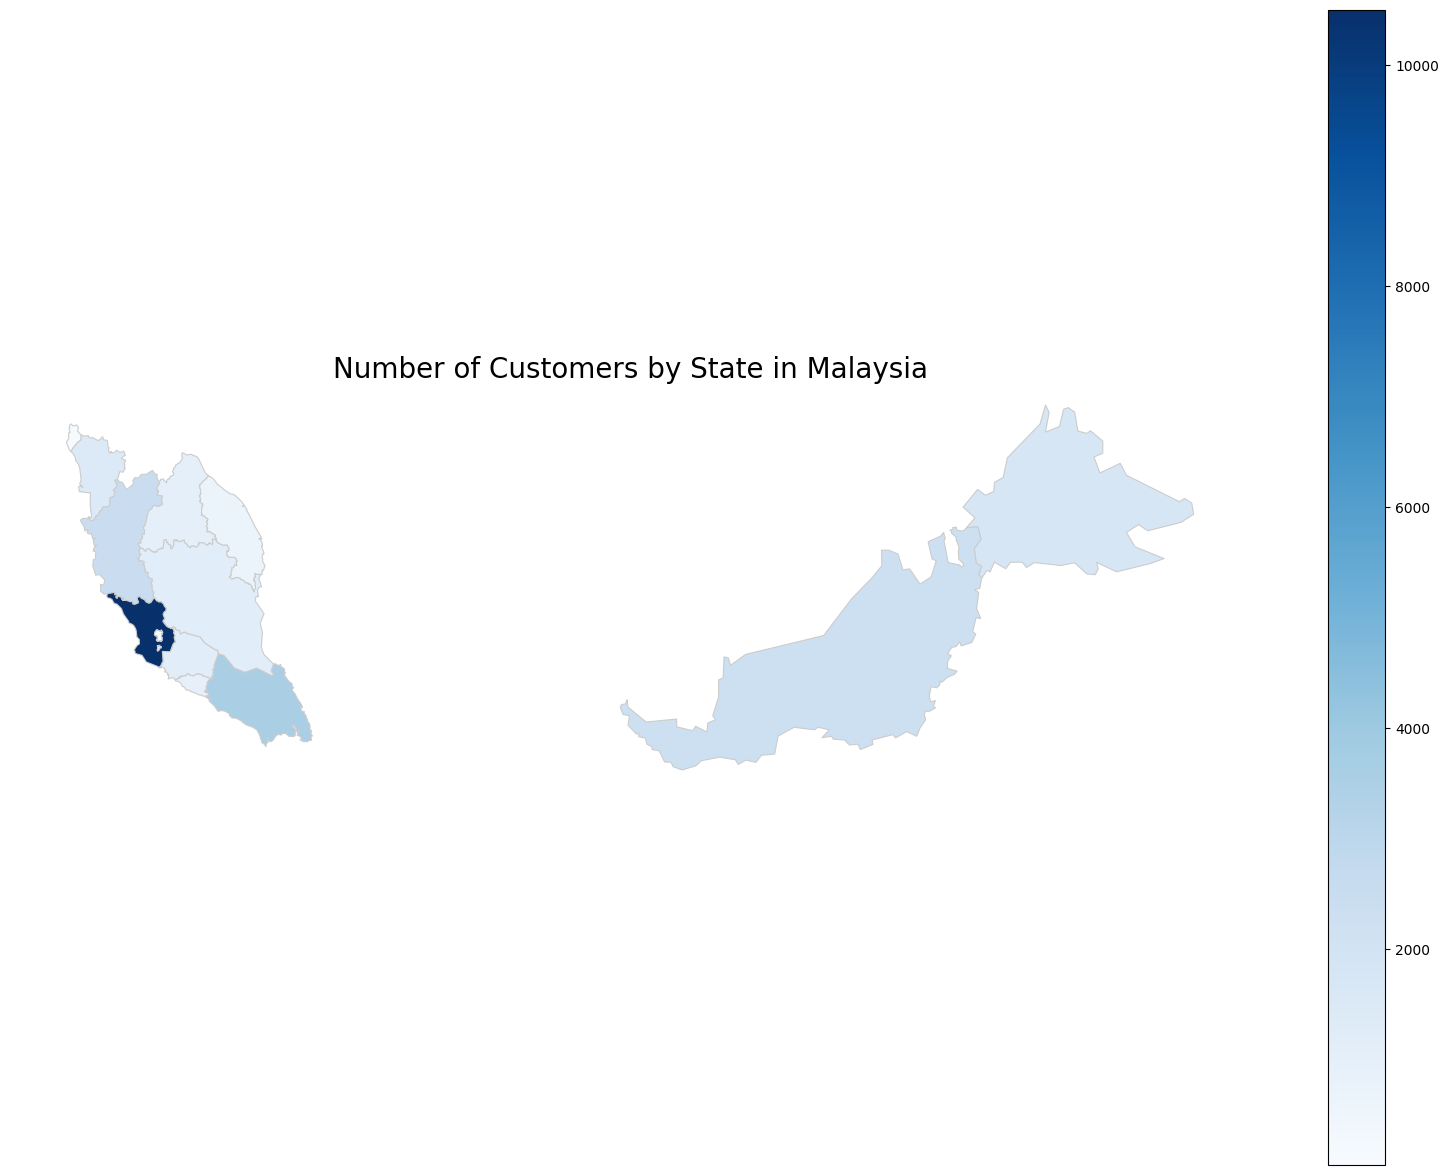

In [31]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Sample data for merge_df (assuming it's already loaded)
# merge_df = pd.read_csv('path_to_your_customer_data.csv', encoding='ISO-8859-1')

# Standardize state names in the customer data
def standardize_state_names(state):
    if pd.isnull(state):
        return state
    state = state.strip().lower()
    state_mapping = {
        'johor': 'johor',
        'kedah': 'kedah',
        'kelantan': 'kelantan',
        'melaka': 'melaka',
        'negeri sembilan': 'negeri sembilan',
        'pahang': 'pahang',
        'perak': 'perak',
        'perlis': 'perlis',
        'penang': 'pulau pinang',  # Assuming 'penang' in customer data should map to 'pulau pinang'
        'sabah': 'sabah',
        'sarawak': 'sarawak',
        'selangor': 'selangor',
        'terengganu': 'terengganu',
        'wp kuala lumpur': 'kuala lumpur',
        'wp labuan': 'labuan',
        'wp putrajaya': 'putrajaya'
    }
    return state_mapping.get(state, state)

# Ensure the column contains only strings
merge_df['residential_address_subdivision'] = merge_df['residential_address_subdivision'].astype(str)

# Apply the standardization function
merge_df['residential_address_subdivision'] = merge_df['residential_address_subdivision'].apply(standardize_state_names)

# Count the number of customers in each state
state_counts = merge_df['residential_address_subdivision'].value_counts().reset_index()
state_counts.columns = ['state', 'account_accountNumber']

# Load the Malaysia GeoJSON file
geojson_path = 'C:/Users/dzulaisar/Downloads/malaysia-with-regions_.geojson'
malaysia = gpd.read_file(geojson_path)

# Standardize state names in the GeoDataFrame
malaysia['name'] = malaysia['name'].apply(lambda x: x.strip().lower())

# Merge the customer data with the GeoDataFrame
malaysia = malaysia.merge(state_counts, how='left', left_on='name', right_on='state')

# Plot the heatmap with a blue color scheme and larger size
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
malaysia.plot(column='account_accountNumber', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.set_title('Number of Customers by State in Malaysia', fontsize=20)
ax.axis('off')

plt.show()


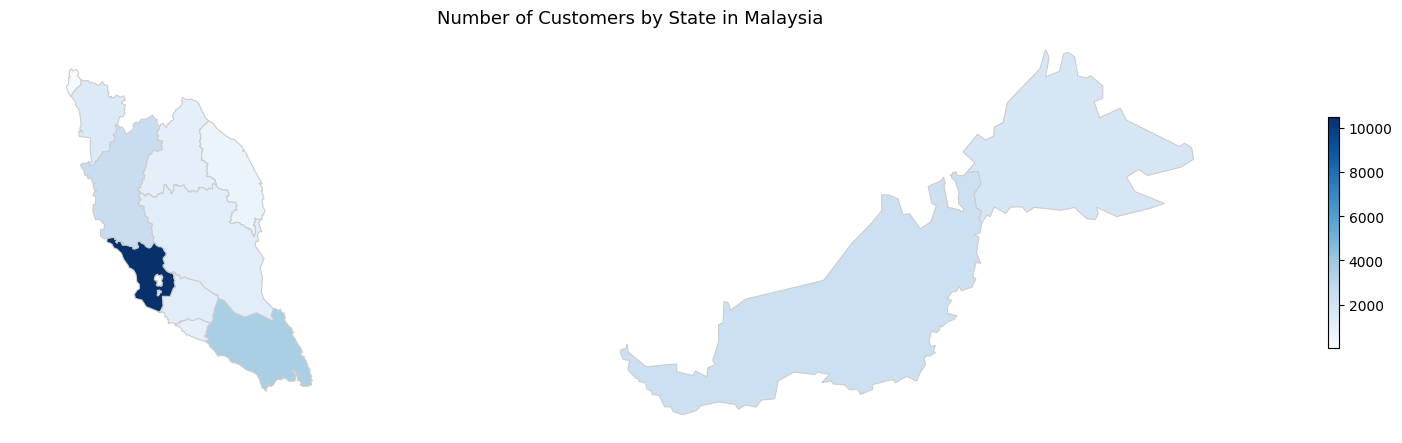

In [54]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Sample data for merge_df (assuming it's already loaded)
# merge_df = pd.read_csv('path_to_your_customer_data.csv', encoding='ISO-8859-1')

# Standardize state names in the customer data
def standardize_state_names(state):
    if pd.isnull(state):
        return state
    state = state.strip().lower()
    state_mapping = {
        'johor': 'johor',
        'kedah': 'kedah',
        'kelantan': 'kelantan',
        'melaka': 'melaka',
        'negeri sembilan': 'negeri sembilan',
        'pahang': 'pahang',
        'perak': 'perak',
        'perlis': 'perlis',
        'penang': 'pulau pinang',  # Assuming 'penang' in customer data should map to 'pulau pinang'
        'sabah': 'sabah',
        'sarawak': 'sarawak',
        'selangor': 'selangor',
        'terengganu': 'terengganu',
        'wp kuala lumpur': 'kuala lumpur',
        'wp labuan': 'labuan',
        'wp putrajaya': 'putrajaya'
    }
    return state_mapping.get(state, state)

# Ensure the column contains only strings
merge_df['residential_address_subdivision'] = merge_df['residential_address_subdivision'].astype(str)

# Apply the standardization function
merge_df['residential_address_subdivision'] = merge_df['residential_address_subdivision'].apply(standardize_state_names)

# Count the number of customers in each state
state_counts = merge_df['residential_address_subdivision'].value_counts().reset_index()
state_counts.columns = ['state', 'account_accountNumber']

# Load the Malaysia GeoJSON file
geojson_path = 'C:/Users/dzulaisar/Downloads/malaysia-with-regions_.geojson'
malaysia = gpd.read_file(geojson_path)

# Standardize state names in the GeoDataFrame
malaysia['name'] = malaysia['name'].apply(lambda x: x.strip().lower())

# Merge the customer data with the GeoDataFrame
malaysia = malaysia.merge(state_counts, how='left', left_on='name', right_on='state')

# Plot the heatmap with a blue color scheme and larger size
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
# Reduce the size of the color bar
malaysia.plot(column='account_accountNumber', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, legend_kwds={'shrink': 0.2})
ax.set_title('Number of Customers by State in Malaysia', fontsize=13)
ax.axis('off')

plt.show()


### Aggregation - Monthly, Weekly and Daily

In [4]:
#Aggregate for daily

# Ensure the 'Accounting Date' is a datetime type
gl['Accounting Date'] = pd.to_datetime(gl['Accounting Date'])

#Filter all the data to select "Accounting Line Type" for CUSTOMER_CMSA and CUSTOMER_CMSA_SAVINGS_POT
gl = gl[gl['Accounting Line Type'].isin(['CUSTOMER_CMSA', 'CUSTOMER_CMSA_SAVINGS_POT'])]

# Add a column for debit (money out) and credit (money in) counts
# Assign 1 to every transaction for counting purposes
gl['Debit_Count'] = (gl['Entered DR'] > 0).astype(int)
gl['Credit_Count'] = (gl['Entered CR'] > 0).astype(int)

# Group by 'Customer Account Number' and 'Accounting Date' (daily as an example)
grouped = gl.groupby(['Customer Account Number', pd.Grouper(key='Accounting Date', freq='D')])

# Aggregate transactions
daily_aggregated_transactions = grouped.agg(
    count_debit=pd.NamedAgg(column='Debit_Count', aggfunc='sum'),
    amount_debit=pd.NamedAgg(column='Entered DR', aggfunc='sum'),
    count_credit=pd.NamedAgg(column='Credit_Count', aggfunc='sum'),
    amount_credit=pd.NamedAgg(column='Entered CR', aggfunc='sum')
)

# Calculate daily balance for each customer account (cumulative credits - cumulative debits)
daily_aggregated_transactions['balance'] = daily_aggregated_transactions.groupby(level=0).cumsum().eval('amount_credit - amount_debit')

# Reset index for daily aggregated transactions
daily_aggregated_transactions = daily_aggregated_transactions.reset_index()

#Save file
daily_aggregated_transactions.to_csv('C:/Users/dzulaisar/Downloads/customer_trend/daily_agg.csv', index=False)

# Display the first few rows to check
daily_aggregated_transactions.head()


,Customer Account Number,Accounting Date,count_debit,amount_debit,count_credit,amount_credit,balance
0,912010110000003,2022-04-04,0,0.0,4,140.0,140.0
1,912010110000003,2022-04-05,5,89.0,4,116.0,167.0
2,912010110000003,2022-04-06,1,9.5,2,209.5,367.0
3,912010110000003,2022-04-07,1,50.0,0,0.0,317.0
4,912010110000003,2022-04-08,1,10.0,1,10.0,317.0


In [5]:
#Aggregate Weekly

# Group by 'Customer Account Number' and 'Accounting Date' (weekly)
weekly_grouped = gl.groupby(['Customer Account Number', pd.Grouper(key='Accounting Date', freq='W')])

#Filter all the data to select "Accounting Line Type" for CUSTOMER_CMSA and CUSTOMER_CMSA_SAVINGS_POT
gl = gl[gl['Accounting Line Type'].isin(['CUSTOMER_CMSA', 'CUSTOMER_CMSA_SAVINGS_POT'])]

# Aggregate transactions for weekly data
weekly_aggregated_transactions = weekly_grouped.agg(
    count_debit=pd.NamedAgg(column='Debit_Count', aggfunc='sum'),
    amount_debit=pd.NamedAgg(column='Entered DR', aggfunc='sum'),
    count_credit=pd.NamedAgg(column='Credit_Count', aggfunc='sum'),
    amount_credit=pd.NamedAgg(column='Entered CR', aggfunc='sum')
)

# Calculate weekly balance for each customer account (cumulative credits - cumulative debits)
weekly_aggregated_transactions['balance'] = weekly_aggregated_transactions.groupby(level=0).cumsum().eval('amount_credit - amount_debit')

# Reset index for daily aggregated transactions
weekly_aggregated_transactions = weekly_aggregated_transactions.reset_index()

#Save file
weekly_aggregated_transactions.to_csv('C:/Users/dzulaisar/Downloads/customer_trend/weekly_agg.csv', index=False)

# Display the first few rows to check weekly data
weekly_aggregated_transactions.head()


,Customer Account Number,Accounting Date,count_debit,amount_debit,count_credit,amount_credit,balance
0,912010110000003,2022-04-10,8,158.50,11,475.50,317.00
1,912010110000003,2022-04-17,3,62.00,1,10.00,265.00
2,912010110000003,2022-05-01,6,160.00,8,200.60,305.60
3,912010110000003,2022-05-08,1,2.00,1,2.00,305.60
4,912010110000003,2022-05-15,1,2.46,1,7.87,311.01


In [6]:
#Monthly Aggregation

# Group by 'Customer Account Number' and 'Accounting Date' (monthly)
monthly_grouped = gl.groupby(['Customer Account Number', pd.Grouper(key='Accounting Date', freq='M')])

#Filter all the data to select "Accounting Line Type" for CUSTOMER_CMSA and CUSTOMER_CMSA_SAVINGS_POT
gl = gl[gl['Accounting Line Type'].isin(['CUSTOMER_CMSA', 'CUSTOMER_CMSA_SAVINGS_POT'])]

# Aggregate transactions for monthly data
monthly_aggregated_transactions = monthly_grouped.agg(
    count_debit=pd.NamedAgg(column='Debit_Count', aggfunc='sum'),
    amount_debit=pd.NamedAgg(column='Entered DR', aggfunc='sum'),
    count_credit=pd.NamedAgg(column='Credit_Count', aggfunc='sum'),
    amount_credit=pd.NamedAgg(column='Entered CR', aggfunc='sum')
)

# Calculate monthly balance for each customer account (cumulative credits - cumulative debits)
monthly_aggregated_transactions['Net Flow'] = monthly_aggregated_transactions.groupby(level=0).cumsum().eval('amount_credit - amount_debit')

# Reset index for daily aggregated transactions
monthly_aggregated_transactions = monthly_aggregated_transactions.reset_index()

#Save file
monthly_aggregated_transactions.to_csv('C:/Users/dzulaisar/Downloads/customer_trend/monthly_agg.csv', index=False)

# Display the first few rows to check monthly data
monthly_aggregated_transactions.head()


C:\Users\skhadijah\AppData\Local\Temp\1\ipykernel_19284\2808606692.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_grouped = gl.groupby(['Customer Account Number', pd.Grouper(key='Accounting Date', freq='M')])


,Customer Account Number,Accounting Date,count_debit,amount_debit,count_credit,amount_credit,Net Flow
0,912010110000003,2022-04-30,17,380.50,20,686.10,305.60
1,912010110000003,2022-05-31,5,60.84,8,262.55,507.31
2,912010110000003,2022-06-30,12,1019.00,21,1087.11,575.42
3,912010110000003,2022-07-31,16,1434.55,15,15344.73,14485.60
4,912010110000003,2022-08-31,44,17878.48,18,11728.59,8335.71
